In [1]:
!pip3 install torch torchvision

In [2]:
import torch
from torchvision import datasets, transforms 
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
import torch.nn.functional as F

<h3>Downloading the MNIST dataset and Creating Batches</h3>

In [3]:
transform = transforms.Compose([transforms.Resize((28,28)), transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))]) 
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform) 

validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)                                                                                              
  
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True) 

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False) 

Creating a function for plotting downloaded MNIST images.

In [4]:
def im_convert(tensor):  #for plotting the downloaded MNIST images we convert it to numpy. function takes tensor as input
  image = tensor.clone().detach().numpy() 

  image = image.transpose(1, 2, 0) # swapping axis(0,1,2)->axis(1,2,0)
  #print(image.shape)
  image = image*np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0,1) #we converted range -1 to 1. so while denormalizing we want it back to 0-1
  return image

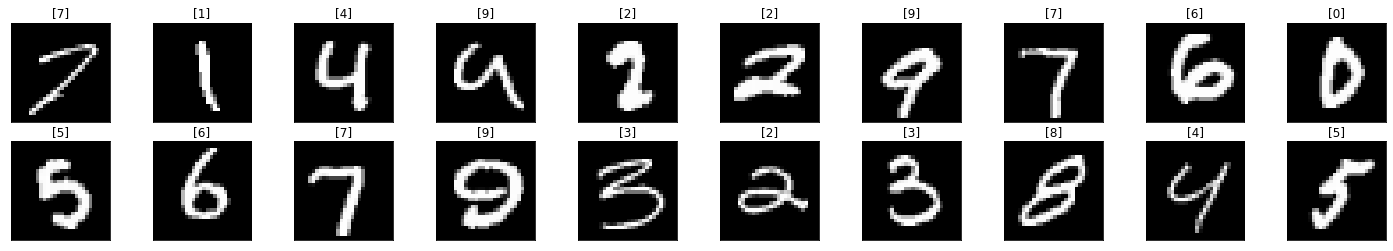

In [5]:
dataiter = iter(training_loader) #wrapping train_loader with iter.creates an object that allows us to go through the iterable(training_loader) 1 data at a time
images, labels = dataiter.next() #accessing each element. wraps 1st batch of training data
fig = plt.figure(figsize = (25, 4))

for i in np.arange(20):

  ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[i])) 
  ax.set_title([labels[i].item()])

<h3>Building the neural network</h3>

In [6]:
class Classifier(nn.Module):
  def __init__(self, D_in, H1, H2, D_out):
    super().__init__()
    self.linear1 = nn.Linear(D_in, H1)
    self.linear2 = nn.Linear(H1, H2)
    self.linear3 = nn.Linear(H2, D_out)

  def forward(self, x):
    x = F.relu(self.linear1(x)) 
    x = F.relu(self.linear2(x))
    x = self.linear3(x) 
    return x  

In [7]:
model = Classifier(784, 125, 65, 10)
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

<h3>Setting the Loss Function and the optimizer for our model</h3>

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001 )

In [9]:
epochs = 15

running_loss_history = [] #for analyzing loss after every epoch with plot
running_corrects_history = [] #for accuracy at every epoch 

val_running_loss_history = [] 
val_running_corrects_history = []

for e in range(epochs):

  running_loss = 0.0 #to keep track of loss at every epoch, b4 every epoch iteration, set var.for loss computed at every single batch, we must add all of them up to compute final loss at every epoch
  running_corrects = 0.0 #we want to compare predictions made by model for each training image to actual labels to see how many correct obtained within epoch

  val_running_loss = 0.0
  val_running_corrects = 0.0 

  for inputs, labels in training_loader: #while iterating through every batch(100 images and labels), we want to plot loss 
    
    inputs = inputs.view(inputs.shape[0],-1) 
     #1,28,28 to 1,784. are multiplied by weights when connected to hidden layer, so convert to 1D (single row of 784 pixels)
    outputs = model(inputs) 
    # calling our forward function which gives raw output
    # outputs contains bunch of score values. class which contains highest score by passing into softmax function will have highest prob.

    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #in outputs=model(inputs) each image gives bunch of scores. we want max score
    
    _, preds = torch.max(outputs, 1) #a tuple of images returned 
    running_corrects += torch.sum(preds == labels.data) #gives sum of all right predictions

    running_loss += loss.item() 
    #then append this accumulated loss for entire epoch into our losses list
    
  else:  #after iterating through the for loop through all batches, we want to print the accumulated loss for all batches

    with torch.no_grad(): #to save memory. sets all reqd grad flags to be False, invokes this block of code as a pair

      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.view(inputs.shape[0],-1) 
        val_outputs = model(val_inputs) 
        val_loss = criterion(val_outputs, val_labels) 
      #since we arent training nn, no need to call optimizer.zero_grad(), loss.backward(), optimizer.step()

        _, val_preds = torch.max(val_outputs, 1)
        val_running_corrects += torch.sum(val_preds == val_labels.data)
        val_running_loss += val_loss.item()

    epoch_loss = running_loss/len(training_loader) #avg loss at each epoch 
    epoch_acc = running_corrects.float()/len(training_loader) #accuracy of epoch

    running_loss_history.append(epoch_loss) #by doing this, we can observe decrease in loss at every single epoch
    running_corrects_history.append(epoch_acc)

    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/len(validation_loader)

    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print("epoch: {}".format(e+1))

    print('training loss: {:.4f}, accuracy: {:.4f}'.format(epoch_loss, epoch_acc.item())) #convert loss to float number with 4 decimal places
    print('validation loss: {:.4f}, accuracy: {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

epoch: 1
training loss: 0.4362, accuracy: 87.2233
validation loss: 0.2514, accuracy: 92.6600
epoch: 2
training loss: 0.2031, accuracy: 93.9467
validation loss: 0.1645, accuracy: 95.1100
epoch: 3
training loss: 0.1501, accuracy: 95.4733
validation loss: 0.1298, accuracy: 95.9600
epoch: 4
training loss: 0.1196, accuracy: 96.3033
validation loss: 0.1187, accuracy: 96.3800
epoch: 5
training loss: 0.1017, accuracy: 96.8783
validation loss: 0.0998, accuracy: 96.9700
epoch: 6
training loss: 0.0881, accuracy: 97.3067
validation loss: 0.1068, accuracy: 96.6500
epoch: 7
training loss: 0.0793, accuracy: 97.5183
validation loss: 0.0991, accuracy: 96.8900
epoch: 8
training loss: 0.0715, accuracy: 97.7750
validation loss: 0.0940, accuracy: 96.9600
epoch: 9
training loss: 0.0635, accuracy: 97.9983
validation loss: 0.0791, accuracy: 97.5900
epoch: 10
training loss: 0.0586, accuracy: 98.1167
validation loss: 0.1105, accuracy: 96.7200
epoch: 11
training loss: 0.0529, accuracy: 98.2833
validation loss: 0

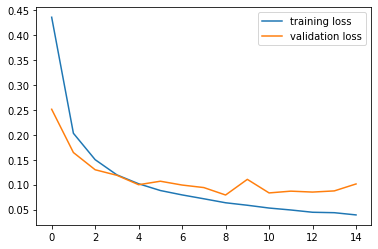

In [10]:
plt.plot(running_loss_history, label="training loss")
plt.plot(val_running_loss_history, label="validation loss")
plt.legend()

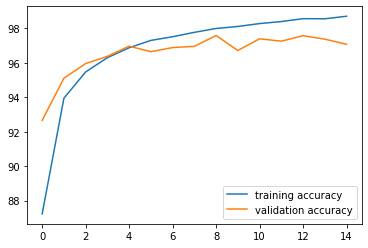

In [11]:
plt.plot(running_corrects_history, label= "training accuracy")
plt.plot(val_running_corrects_history, label= "validation accuracy")
plt.legend()

Till now model performed well on training data. Checking if will it do the same on validation data.

In [12]:
import PIL.ImageOps

<h3>Model Testing : Image of digit '5'</h3>

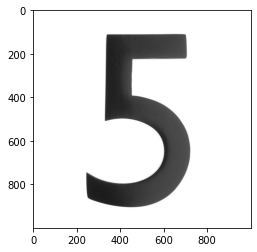

In [13]:
import requests
from PIL import Image

url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

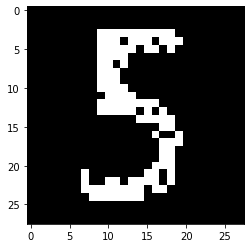

In [14]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img) 
plt.imshow(im_convert(img))

In [15]:
img = img.view(img.shape[0], -1)
output = model(img)
_, pred = torch.max(output, 1)
print(pred.item())

5


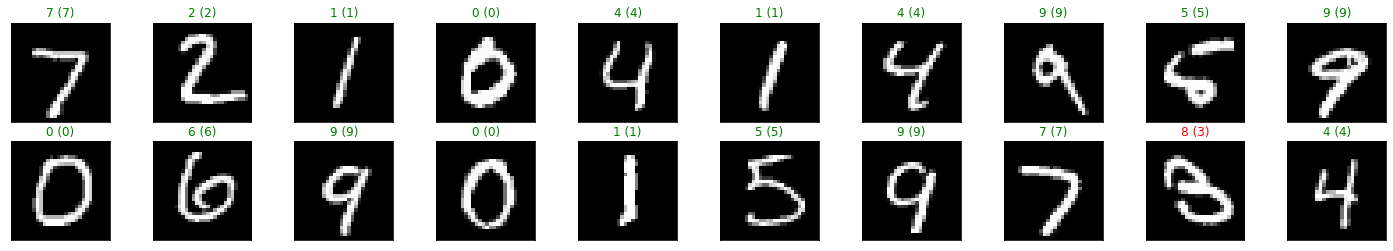

In [16]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images_ = images.view(images.shape[0], -1)
output = model(images_)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))